In [1]:
#%matplotlib inline

# %load_ext autoreload
# %autoreload 2

import time
import os
import logging
#from functools import wraps
from copy import deepcopy
import dill
import sys
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pickle
#from tqdm.autonotebook import tqdm, trange

# from IPython.display import display
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets


# torch packages
import torch
import torch.optim as optim
import torch.nn as nn
import torch.distributions as dist

from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import v2

#from torchvision.utils import make_grid
from torchsummary import summary


#import torch.nn.functional as F

FILENAME = 'SIC_Sharp_3.0_VAE'

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("logs/"+FILENAME+"_" + time.strftime("%Y%m%d-%H%M%S")+ ".txt"),
        #logging.StreamHandler()  #logs to console as well
    ]
)

# Create a logger
logger = logging.getLogger(__name__)

#import custom modules
sys.path.append(r'../src/modules/')

from plot_jupyter import contour_compare, contour_data
from data_wrangle import get_days_before, get_test_set, window_mean, get_days_after

In [2]:
#seed for repeatable results
torch.manual_seed(0)

gen1 = torch.Generator().manual_seed(0)

# if training needs to be run

epochs = 500

run_training = True

if not run_training:
    load_ext = True
    model_enc = '../outputs/model_outputs/sic_enc_single_nomask_latent64_1000_20240709-171931.pt'
    model_dec = '../outputs/model_outputs/sic_dec_single_nomask_latent64_1000_20240709-171931.pt'
else:
    load_ext = False

clamp_yn = True


In [3]:
def get_ice_data(data_loc = r'C:/Project/data/data314_years_1989_2023.pkl' , return_mask = True):
    with open(data_loc, 'rb') as f:
        m, Y, Y_mean_month, Y_mean_week, x2, y2 = dill.load(f)
    # mask = array of T/F plotting out the land mass of Antartica
    #DATA = Y
    #x = x2
    #y = y2
    #del Y_mean_month, Y_mean_week
    if return_mask:
        return Y,  ~m  
    else:
        return Y


def thin_data(data_input, mask_input, step_thin, print_shape = True):
    # step parameter
    #step_thin = step_size

    # ~ is a binary operator flips 1 to 0 and vice versa
    mask = mask_input[::step_thin, ::step_thin]
    # reducing the data set size with the step paramter only for model searching/training

    DATA = []
    for year in range(len(data_input)):
        #y0 = Y[year][:, ::step_thin, ::step_thin]
        DATA.append(data_input[year][:, ::step_thin, ::step_thin])

    #check shape
    if print_shape:
        DATA[0].shape
    
    return DATA, mask

In [4]:
sic_data, _ = get_ice_data()

#check data with a plot
# fig_1, ax_1 = plt.subplots(figsize=(5,4))
# ax_1.contourf(sic_data[30][350], cmap=plt.get_cmap('Blues_r'))
# ax_1.set_ylim(314, 0)
# fig_1.show()


#check thinned data with a plot
# plt.contourf(DATA[30][350], cmap=plt.get_cmap('Blues_r'))
# plt.show()

In [5]:
def iiee_calc(c_m, c_o, c_e = 0.15, iiee_only =True):

    """
    Torch implementation of Integrated Ice Edge error calcuation

    c_m = model image
    c_o = obersevation image

    c_e = edge variable, set to 0.15 as per ....

    Returns:

    """
    model_edge  = c_m >= c_e
    observed_edge = c_o >= c_e

    a_pos = torch.logical_and(model_edge, ~observed_edge)
    a_neg = torch.logical_and(~model_edge, observed_edge)

    a_pos_area = torch.sum(a_pos)
    a_neg_area = torch.sum(a_neg)

    iiee = a_pos_area + a_neg_area
    bias = a_pos_area - a_neg_area

    if iiee_only:
        return iiee
    else:
        return iiee, bias, a_pos_area, a_neg_area
    
    
batched_iiee = torch.func.vmap(iiee_calc)
batched_min = torch.func.vmap(torch.min)
batched_max = torch.func.vmap(torch.max)


def normalise_image_single(in_data):
    return (in_data - in_data.min())/(in_data.max() - in_data.min())


def normalise_imagev2(in_data):

    if in_data.dim() > 3:
        in_data1 = in_data.permute(1,0,2,3)
        minval = in_data1[0].min(1)[0].min(1)[0]
        maxval = in_data1[0].max(1)[0].max(1)[0]
    else:
        in_data1 = in_data
        minval = in_data1.min(1)[0].min(1)[0]
        maxval = in_data1.max(1)[0].max(1)[0]

    return (in_data - minval[:,None,None,None])/(maxval[:,None,None,None] - minval[:,None,None,None])


def normalise_image(in_data):

    if in_data.dim() > 3:
        in_data1 = in_data.permute(1,0,2,3)
        minval = batched_min(in_data1[0])
        maxval = batched_max(in_data1[0])
    else:
        in_data1 = in_data
        minval = batched_min(in_data1)
        maxval = batched_max(in_data1)

    return (in_data - minval[:,None,None,None])/(maxval[:,None,None,None] - minval[:,None,None,None])


def numpy_mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean()

In [6]:
year = 28 # year within data set
day = 0 # day within year as the starting point 
window = 1 # window-averaging
num_year_data = 28 # number of years worth of data
T_train = 365 * num_year_data  # how many days worth of data needed
batchSize = 325  #batch size for dataloader
dim_latent = 5

X0_ = get_days_before(sic_data, year, day, T_train+window-1)

all_data = np.array(X0_)

# data_max ,data_min, data_avg = all_data.max(), all_data.min(), all_data.mean()

# data_max ,data_min, data_avg

#numpy array to torch tensor
all_data = torch.Tensor(all_data)[:,None,:,:]

#mask_tensor = torch.Tensor(np.tile(mask, (X0_.shape[0],1,1,1))).bool()

X1_ = get_days_after(sic_data, year, day,  365*2)

# all_test_data = np.array(X1_)
# all_test_data = torch.Tensor(all_test_data)[:,None,:,:]

train_count = 23*365
val_split = 5*365

all_data_train, all_data_val = torch.utils.data.random_split(all_data, [train_count, val_split], generator=gen1)

full_all_data = torch.utils.data.ConcatDataset([all_data, v2.functional.vflip(all_data), v2.functional.hflip(all_data)])

full_data_train, full_data_val = torch.utils.data.random_split(full_all_data, [train_count*3, val_split*3], generator=gen1)

In [7]:
#train and test dataloaders

#train_loader_sic = torch.utils.data.DataLoader(dataset=all_data, batch_size=batchSize, shuffle=True)

train_loader_sic = torch.utils.data.DataLoader(dataset=all_data_train, batch_size=batchSize, shuffle=True)

val_loader_sic  = torch.utils.data.DataLoader(dataset=all_data_val, batch_size=batchSize, shuffle=True)

# train_loader_sic = torch.utils.data.DataLoader(dataset=full_data_train, batch_size=batchSize, shuffle=True)

# val_loader_sic  = torch.utils.data.DataLoader(dataset=full_data_val, batch_size=batchSize, shuffle=True)

In [8]:
# img = all_data[0][None,...]


# #maxpool = nn.MaxPool2d(4)

# # img = nn.Conv2d(1, 4, kernel_size=2)(img)
# # img = nn.Dropout2d(p=0.1)(img)
# # img = nn.ReLU()(img)
# img = nn.Conv2d(1, 8, kernel_size=5)(img)
# img = nn.Conv2d(8, 8, kernel_size=5)(img)
# img = nn.Conv2d(8, 8, kernel_size=5)(img)
# #nn.Dropout2d(p=0.1),
# img = nn.BatchNorm2d(8)(img)
# img = nn.ReLU()(img)
# img = nn.Conv2d(8, 16, kernel_size=5, stride=1)(img)
# img = nn.Conv2d(16, 16, kernel_size=5, stride=1)(img)
# img = nn.Conv2d(16, 16, kernel_size=5, stride=1)(img)
# #nn.Dropout2d(p=0.1),
# img = nn.BatchNorm2d(16)(img)
# img =nn.ReLU()(img)
# img = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=2)(img)
# img = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=2)(img)
# img = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=2)(img)
# #nn.Dropout2d(p=0.1),
# img = nn.BatchNorm2d(32)(img)
# img =nn.ReLU()(img)
# img = nn.Conv2d(32, 64, kernel_size=3)(img)
# img = nn.Conv2d(64, 64, kernel_size=3)(img)
# img = nn.Conv2d(64, 64, kernel_size=3)(img)
# img = nn.BatchNorm2d(64)(img)
# img = nn.Flatten()(img)
# img = nn.Linear(2304, 64)(img)
# #img = maxpool(img)
# # img = nn.Flatten()(img)
# # img = nn.Linear(3136, 64)(img)

In [9]:
def reparameterize(mu, logvar):
    """
    Reparameterization trick to sample from N(mu, var) from
    N(0,1).
    :param mu: (Tensor) Mean of the latent Gaussian [B x D]
    :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
    :return: (Tensor) [B x D]
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps * std + mu

In [10]:
class Encoder_sharp(nn.Module):
    
    def __init__(self, d_latent = 64):
        """ 
        Encoder using `nn.Module`. Series of 2d-Convolutions, dropouts and Relus

        """
        super().__init__()
        self.d_latent = d_latent
        self.layers = nn.Sequential(
                                        # nn.Conv2d(1, 8, kernel_size=3),
                                        # nn.ReLU(),
                                        #nn.MaxPool2d(2),
                                        nn.Conv2d(1, 16, kernel_size=3),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2),
                                        nn.BatchNorm2d(16),
                                        nn.Conv2d(16, 32, kernel_size=3),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2),
                                        nn.Conv2d(32, 64, kernel_size=3),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2),
                                        nn.BatchNorm2d(64)
                                        # nn.Conv2d(64, 64, kernel_size=3),
                                        # nn.ReLU(),
                                        # nn.MaxPool2d(2),
                                        # nn.BatchNorm2d(64),
                                        #nn.Flatten()
                                        #nn.Linear(87616, self.d_latent)
                                    )
        
        self.mu_vector = nn.Sequential(nn.Flatten(), nn.Linear(in_features = 87616, out_features = d_latent))
        self.sigma_vector = nn.Sequential(nn.Flatten(), nn.Linear(in_features = 87616, out_features = d_latent)) 
        self.softplus = nn.Softplus()
    def forward(self, X):
        h1 = self.layers(X)
        #h1 = self.layers2(h1)
        
        mu = self.mu_vector(h1)
        sigma = torch.exp(self.sigma_vector(h1))
        log_sigma = self.sigma_vector(h1)

        scale = self.softplus(log_sigma) + 1e-8 #eps
        scale_tril = torch.diag_embed(scale)

        assert mu.shape == (X.shape[0], self.d_latent)
        assert mu.shape == sigma.shape
        assert mu.shape == log_sigma.shape

        #return mu, log_sigma

        #return dist.Normal(loc  = mu, scale = sigma)
        #return h1
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

In [11]:
class Decoder_sharp(nn.Module):
    # no max pool used in encoder
    def __init__(self,d_latent = 64):
        """ 

        """
        super().__init__()
        self.d_latent = d_latent
        self.layers = nn.Sequential(
                                    nn.Linear(self.d_latent, 87616),
                                    nn.ReLU(),
                                    nn.Unflatten(1, (64, 37, 37)),
                                    nn.ConvTranspose2d(64, 32, kernel_size=5, stride = 2),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(32, 16, kernel_size=5, stride = 2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(16, 8, kernel_size=3, stride = 2),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(8, 4, kernel_size=3),
                                    nn.BatchNorm2d(4),
                                    nn.ReLU(),
                                    nn.Conv2d(4, 1, kernel_size=3),
                                    nn.Conv2d(1, 1, kernel_size=2),
                                    nn.BatchNorm2d(1),
                                    #nn.Sigmoid()
                                    )    
        #self.sigmoid = nn.Sigmoid()
    def forward(self, Z):
        h1 = self.layers(Z)
        #h1 = self.sigmoid(h1)
        #a = 1
        #return dist.continuous_bernoulli.ContinuousBernoulli(h1.reshape(-1, 1, 314, 314))
        return h1

In [12]:
enc = Encoder_sharp(d_latent=dim_latent)
dec = Decoder_sharp(d_latent=dim_latent)

if torch.cuda.is_available():
    enc.to("cuda")  
    dec.to("cuda")  

#summary(enc, (1,314,314))

In [13]:
def ELBO_VAE(enc, dec, X):
    """
    
    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution 
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution 
          over X when called on a batch of inputs Z
    X   : A batch of datapoints
    
    OUTPUT: a torch.FloatTensor of shape = (batch_size, ) containing the estimate 
            of the per-datapoint ELBO for every data point in the batch.
    
    """
    # batchsize = X.shape[0]

    dist = enc(X)
    
    z = dist.rsample()
    
    recon = dec(z).clamp(min=0, max= 1) #add clamp check 

    #p_x_z = initiate_decoder.log_prob(X).reshape(batchsize,-1).sum(1)
    
    #q_z_x = initiate_encoder.log_prob(z).sum(1)

      # elbo loss / kl div  = q(z|x) - p(z)
      # recon loss = p(x|z)
    #kld_weight = 1 # Account for the minibatch samples from the dataset
    
    recon_loss = mse_loss(recon, X)
    
    std_normal = torch.distributions.MultivariateNormal(torch.zeros_like(z, device=z.device), scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),)
    
    loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
    
    loss = recon_loss + loss_kl

    return loss


In [14]:
#a = 

In [15]:
def _lr_lambda(current_step):
        """
        _lr_lambda returns a multiplicative factor given an interger parameter epochs.
        """

        if current_step < 5:
            _lr =1.0
        elif current_step < 10:
            _lr = 0.1
        elif current_step < 20:
            _lr = 0.01

        elif current_step < 30:
            _lr = 0.001
        else:
            _lr = .0001

        return _lr


In [16]:
#### Turn into a function with loss type, normalise type, weight decay, learning rate, print paramters, print at all ####

#### Need to take avg loss and compare for early stopping criteria ####

#### more epochs => significant overfitting ####

#### Retrain on full training set after finding optimal epoch range ####

mse_multp = 1.0
iiee_multp = 1.0

if run_training:
    # define loss and parameters
    enc.train()
    dec.train()

    optimizer = optim.AdamW(itertools.chain(enc.parameters(), dec.parameters()), lr=0.0001)
    #lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=_lr_lambda)
    #mask_tensor = mask_tensor.cuda()
    #loss multipliers
    train_loss = []
    val_loss = []

    print('====Training start====')
    for epoch in range(epochs):
        total_mseloss = 0.0
        total_iieeloss = 0.0
        total_val_loss = 0.0
        total_train_loss = 0.0

        for batch_idx, data in enumerate(train_loader_sic):
            # prepare input data
            img = data.to("cuda")
            
            #img = img*mask_tensor[:img.shape[0],...]
            elbos = ELBO_VAE(enc, dec, img)
            #output_en = enc(img)
            #output = dec(output_en)
            loss = elbos

            # if clamp_yn == True:
            #     output_norm = output.clamp(min=0, max= 1)#*mask_tensor
            # else:
            #     output_norm = normalise_image(output)

            #output_norm = normalise_image(output)
            
            #loss_mse = mse_loss(output_norm, img)
            #loss_iiee = torch.sum(batched_iiee(output_norm, img))

            #loss = (mse_multp * loss_mse) + (loss_iiee * iiee_multp) 
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track this epoch's loss
            #total_mseloss += loss_mse.item()
            #total_iieeloss += loss_iiee.item()
            #total_train_loss += total_mseloss +total_iieeloss
            
            total_train_loss += loss.item() * img.shape[0] / len(full_data_train)
            # if epoch==0 or epoch ==10:    
            #     print(list(enc.parameters())[0]) 
            #total_clsloss += loss_cls.item()

            # validation step 
        #lr_scheduler.step()
        train_loss.append([total_train_loss])

        enc.eval()
        dec.eval()

        with torch.no_grad():
            for batch_idx_val, data_val in enumerate(val_loader_sic):

                img_val = data_val.to("cuda")#, data[1].to("cuda") 
                
                #img_val = img_val*mask_tensor[:img_val.shape[0],...]
                
                elbos = ELBO_VAE(enc, dec, img_val)
                #output_en = enc(img)
                #output = dec(output_en)
                loss = elbos.sum()

                # if clamp_yn == True:
                #     output_norm = output.clamp(min=0, max= 1)#*mask_tensor
                # #output_norm = normalise_image(output*mask_tensor[:img_val.shape[0],...])
                # else:
                #     output_norm = normalise_image(output)

                #val_loss_mse = mse_loss(output_norm, img_val)
                #val_loss_iiee = torch.sum(batched_iiee(output_norm, img_val))

                #total_val_loss = (mse_multp * val_loss_mse) + (val_loss_iiee * iiee_multp) 
                total_val_loss +=  loss.item() * img_val.shape[0] / len(full_data_val)

            val_loss.append([ total_val_loss])

        enc.train()
        dec.train()

        if epoch%10==0:    
            print('====> Epoch: {} Total loss: {:.4f} Total MSE Loss: {:.4f} Validation loss: {:.4f}'.format(epoch, total_train_loss, 0, total_val_loss))
    print('====Training finish====')

    torch.save(enc, '../outputs/model_outputs/sic_enc_vae_latent'+ str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"))
    torch.save(dec, '../outputs/model_outputs/sic_dec_vae_latent'+ str(dim_latent)+'_'+ str(epochs) +'_' +  time.strftime("%Y%m%d-%H%M%S"))

====Training start====


c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


====> Epoch: 0 Total loss: 4.6050 Total MSE Loss: 0.0000 Validation loss: 0.1675
====> Epoch: 10 Total loss: 0.0541 Total MSE Loss: 0.0000 Validation loss: 0.0552
====> Epoch: 20 Total loss: 0.0405 Total MSE Loss: 0.0000 Validation loss: 0.0417
====> Epoch: 30 Total loss: 0.0271 Total MSE Loss: 0.0000 Validation loss: 0.0287
====> Epoch: 40 Total loss: 0.0250 Total MSE Loss: 0.0000 Validation loss: 0.0267
====> Epoch: 50 Total loss: 0.0241 Total MSE Loss: 0.0000 Validation loss: 0.0262
====> Epoch: 60 Total loss: 0.0242 Total MSE Loss: 0.0000 Validation loss: 0.0254
====> Epoch: 70 Total loss: 0.0244 Total MSE Loss: 0.0000 Validation loss: 0.0255
====> Epoch: 80 Total loss: 0.0290 Total MSE Loss: 0.0000 Validation loss: 0.0293
====> Epoch: 90 Total loss: 0.0270 Total MSE Loss: 0.0000 Validation loss: 0.0258
====> Epoch: 100 Total loss: 0.0297 Total MSE Loss: 0.0000 Validation loss: 0.0293
====> Epoch: 110 Total loss: 0.0379 Total MSE Loss: 0.0000 Validation loss: 0.0276
====> Epoch: 12

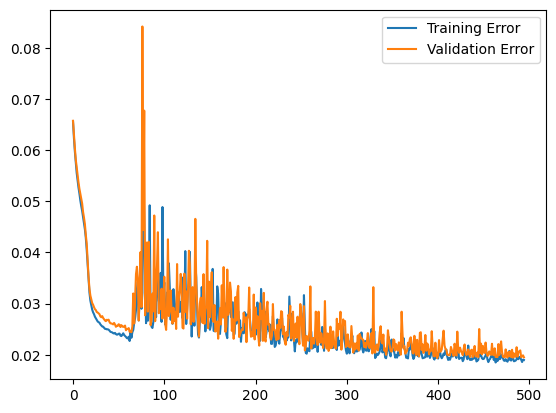

In [17]:
# collect loss and add plot 
if run_training:
    train_loss_np = np.array(train_loss)
    val_loss_np = np.array(val_loss)

    with open(r'../outputs/pickle_outputs/train_loss_latent' + str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"), 'wb') as output:
        pickle.dump(train_loss_np, output)

    with open(r'../outputs/pickle_outputs/val_loss_latent' + str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"), 'wb') as output:
        pickle.dump(val_loss_np, output)

    plt.plot(train_loss_np[5:,0], label = "Training Error")
    # plt.legend()
    # plt.show()
    plt.plot(val_loss_np[5:,0], label = "Validation Error")
    plt.legend()
    plt.show()

In [18]:
## load models ###
if load_ext:
    trained_enc  = Encoder_sharp()
    trained_dec = Decoder_sharp()

    trained_enc = torch.load(model_enc)
    trained_dec = torch.load(model_dec)
else:
    trained_enc  = enc
    trained_dec = dec

enc.eval()
dec.eval()

trained_enc.eval()
trained_dec.eval()

Decoder_sharp(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=87616, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 37, 37))
    (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1))
    (16): Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))
    (17): BatchNor

In [19]:
#a = 

In [20]:
def test_data_stats(test_data,clamp_yn,encoder, decorder ):

    X_test_all = torch.Tensor(test_data)[:,None,...].cuda()

    enc_test = encoder(X_test_all)

    if clamp_yn == True:
        dec_test = decorder(enc_test).clamp(min=0, max= 1)
    else:
        dec_test = normalise_image(decorder(enc_test))#*mask_tensor[:730,:,:,:])

    X_test, dec_test = X_test_all.permute(1,0,2,3)[0], dec_test.permute(1,0,2,3)[0]

    x_true, x_predict = X_test.flatten(), dec_test.flatten()

    err = (x_true - x_predict)**2

    total_err =  err.sum().detach().cpu().numpy()
    avg_err = total_err/err.shape[0]

    print("Total square error: {:.4f}, MSE: {:.4f} RMSE: {:.4f}".format(total_err,avg_err, np.sqrt(avg_err)))

    #iiee
    test_iiee = iiee_calc(dec_test, X_test)

    print("Total iiee: {:.4f}".format(test_iiee))

    return total_err, avg_err, np.sqrt(avg_err), test_iiee


In [21]:
trained_enc_cpu = trained_enc.cpu()
trained_dec_cpu = trained_dec.cpu()

In [22]:
test_set_encoded = trained_enc_cpu(torch.Tensor(X1_)[:,None,:,:])

In [23]:
z = test_set_encoded.rsample()

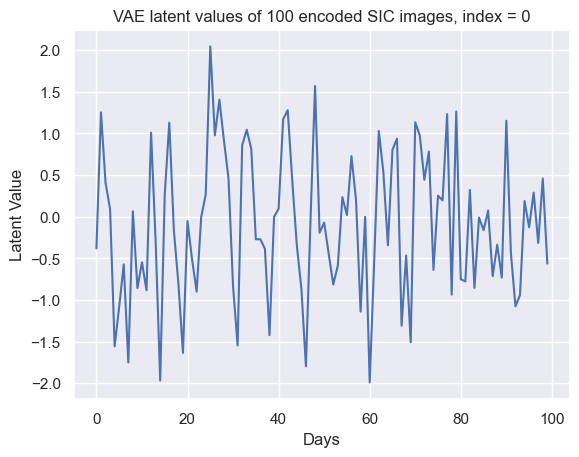

In [49]:
plt.plot(z.detach().numpy()[:100,0])
plt.title("VAE latent values of 100 encoded SIC images, index = 0")
plt.xlabel("Days")
plt.ylabel("Latent Value")
plt.show()

In [25]:
test_set_decoded = trained_dec_cpu(z)

In [26]:
test_set_decoded_np = test_set_decoded.permute(1,0,2,3).clamp(0,1).detach().numpy()[0]


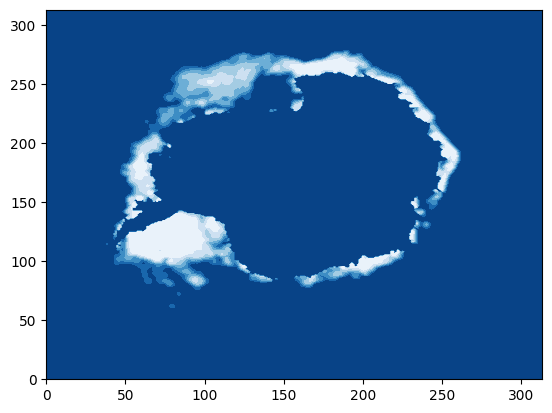

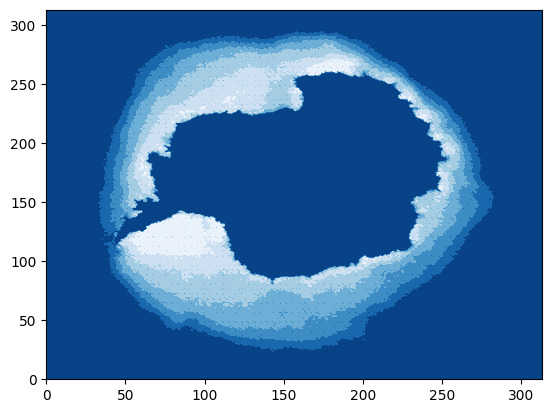

In [27]:
plt.contourf(X1_[0], cmap = "Blues_r")
plt.show()

plt.contourf(test_set_decoded_np[1], cmap = "Blues_r")
plt.show()

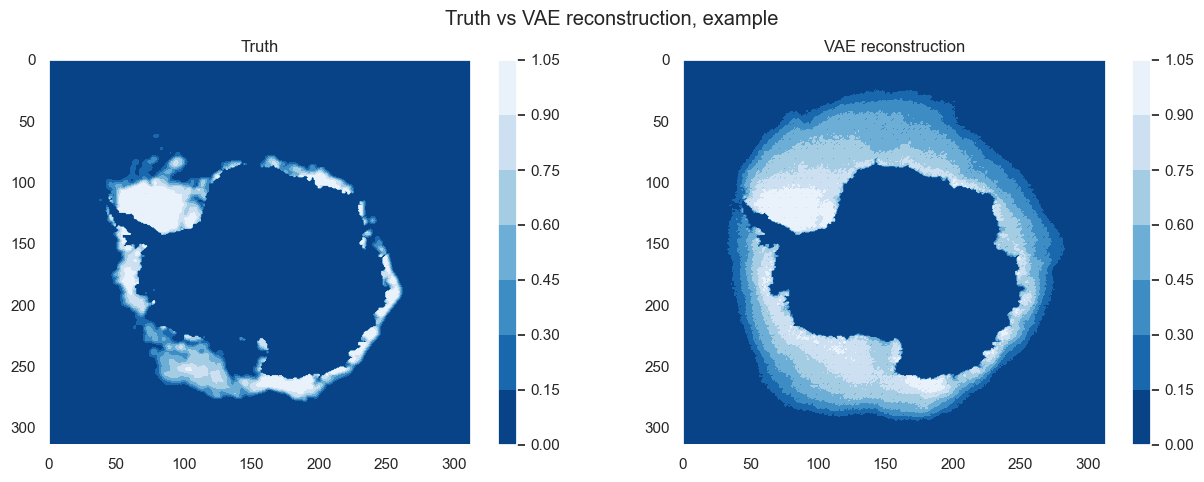

In [43]:
"""VAE comparison"""

import seaborn as sns

fig_1, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sns.color_palette("crest", as_cmap=True)

ax_1 = ax1.contourf(X1_[0], cmap=plt.get_cmap('Blues_r'))
ax1.set_title("Truth")
ax1.set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_2 = ax2.contourf(test_set_decoded_np[1], cmap=plt.get_cmap('Blues_r'))
ax2.set_title("VAE reconstruction")
ax2.set_ylim(314, 0)
cbar2 = fig_1.colorbar(ax_2)

sns.set(style="darkgrid")

fig_1.suptitle("Truth vs VAE reconstruction, example")
plt.show()

In [28]:
plt.figure(figsize=(12,5))
with torch.no_grad():
    plt.imshow(make_grid(dec(dist.Normal(0, 1).sample((140, D_latent))).mean.round(), nrow=20).permute(1,2,0), vmin=0, vmax=1)

NameError: name 'make_grid' is not defined

<Figure size 1200x500 with 0 Axes>

In [ ]:
test_loss_tuple = test_data_stats(X1_,clamp_yn,trained_enc, trained_dec)

with open(r'../outputs/pickle_outputs/test_loss' + str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"), 'wb') as output:
        pickle.dump(test_loss_tuple, output)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not MultivariateNormal

In [ ]:
X0_DMD_train_orig = get_days_before(sic_data, year, day, 365*2+window-1)

X0_DMD_train = torch.Tensor(X0_DMD_train_orig)[:,None,:,:]

In [ ]:
## Get SVD of dataset ###
U,S, Vh = torch.linalg.svd(torch.Tensor(X0_DMD_train_orig))

# set up temporal range
t_delay_bwd = [-i for i in range(730)]

t_delay_fwd = [i for i in range(730)]

t_delay_bwd.sort(reverse=False)
t_delay_fwd.sort()

t_delay = t_delay_bwd + t_delay_fwd

t_delya_arr = np.array(t_delay)

In [ ]:
latent_dmd = DMD(svd_rank=4)

#latent_dmd_delay = hankel_preprocessing(latent_dmd, d=100)

latent_bopdmd = BOPDMD(svd_rank=4, eig_constraints={
                                "stable", # choose Re(lambda)<0
                                "conjugate_pairs", # force complex conjugate pairs
                                })


In [ ]:
def dmd_calculations(x_train_dmd, trained_enc, trained_dec,std_dmd, bop_dmd, n_steps):
    
    x_train_dmd = x_train_dmd.cuda()
    latent_output = trained_enc(x_train_dmd)
    latent_output_cpu = latent_output.detach().cpu().numpy().T

    std_dmd.fit(latent_output_cpu)
    std_dmd.dmd_time["tend"] = std_dmd.original_time["tend"] + len(n_steps)

    bop_dmd.fit(latent_output_cpu,t = n_steps)

    std_recon = std_dmd.reconstructed_data

    bop_recon = bop_dmd.reconstructed_data

    n_steps_fwd = np.array([i+len(n_steps) for i in n_steps])

    bop_forecast = bop_dmd.forecast(n_steps_fwd)

    bop_reconforecast = np.hstack((bop_recon,bop_forecast))

    bop_forecast_dec = trained_dec(torch.Tensor(bop_forecast.T).cuda()).permute(1,0,2,3).detach().cpu().numpy()

    std_dmd_mse = numpy_mse(latent_output_cpu, std_recon[:,:latent_output_cpu.shape[1]])

    bop_dmd_mse = numpy_mse(latent_output_cpu, bop_recon)

    return n_steps_fwd, std_dmd, bop_dmd, latent_output_cpu, std_recon, bop_recon, bop_forecast, bop_reconforecast, bop_forecast_dec, std_dmd_mse, bop_dmd_mse

In [ ]:
dmd_calcs = dmd_calculations(X0_DMD_train, trained_enc, trained_dec,latent_dmd, latent_bopdmd, np.array(t_delay_fwd))

#a1 = dmd_calcs[8]

forecast_mse = numpy_mse(dmd_calcs[8][0].clamp(0,1), X1_)

mse_perimage = ((dmd_calcs[8][0].clamp(0,1) - X1_)**2).sum(axis=(1,2))/(X1_.shape[2]**2)

plt.plot(mse_perimage)
plt.show()

mse_avg = mse_perimage.sum()/X1_.shape[0]

forecase_iiee = batched_iiee(torch.Tensor(dmd_calcs[8][0]), torch.Tensor(X1_))

plt.plot(forecase_iiee)
plt.show()

In [ ]:
svds = [3,4,5,7,10,-1]

dmd_stats = {}

for i in svds:

    latent_dmd_run = DMD(svd_rank=i)
    latent_bopdmd_run = BOPDMD(svd_rank=i, eig_constraints={
                                "stable", # choose Re(lambda)<0
                                "conjugate_pairs", # force complex conjugate pairs
                                })
    dmd_calcs_outputs = dmd_calculations(X0_DMD_train, trained_enc, trained_dec,latent_dmd_run, latent_bopdmd_run, np.array(t_delay_fwd))
    
    mse_perimage = ((dmd_calcs_outputs[8][0] - X1_)**2).sum(axis=(1,2))/(X1_.shape[2]**2)

    forecase_iiee_run = batched_iiee(torch.Tensor(dmd_calcs_outputs[8][0]), torch.Tensor(X1_))

    dmd_stats[i] = [dmd_calcs_outputs, mse_perimage, forecase_iiee_run]


with open(r'../outputs/pickle_outputs/dmd_stats' + str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"), 'wb') as output:
        pickle.dump(dmd_stats, output)

In [ ]:
# Psi_ = latent_dmd.modes # DMD modes
# Lambda_ = latent_dmd.eigs # Get eigenvalues:
# bn_ = latent_dmd.amplitudes # The b_n: IC, expressed in modes basis
# #plot_summary(latent_dmd)

# Psi_bop = latent_bopdmd.modes # DMD modes
# Lambda_bop = latent_bopdmd.eigs # Get eigenvalues:
# bn_bop = latent_bopdmd.amplitudes # The b_n: IC, expressed in modes basis
# #plot_summary(latent_bopdmd)

In [ ]:
## Plot the latent space and repsective reconstructions & forward predictions

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.axvline(len(t_delay_fwd), linestyle = '--', color = 'k')
plt.plot(dmd_calcs[3].T)
plt.subplot(1,2,2)
plt.axvline(len(t_delay_fwd), linestyle = '--', color = 'k')
plt.plot(dmd_calcs[4].T)
plt.show()


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.axvline(len(t_delay_fwd), linestyle = '--', color = 'k')
plt.plot(dmd_calcs[3].T)
plt.subplot(1,2,2)
plt.axvline(len(t_delay_fwd), linestyle = '--', color = 'k')
plt.plot(dmd_calcs[7].T)
plt.show()


In [ ]:
#a = 

In [ ]:
trained_enc_cpu = trained_enc.cpu()
trained_dec_cpu = trained_dec.cpu()

enc_test = trained_enc_cpu(torch.Tensor(X1_)[:,None,:,:])

dec_test = trained_dec_cpu(enc_test).clamp(0,1)
dec_test_arr = dec_test.permute(1,0,2,3).detach().numpy()[0]

In [ ]:
contour_compare(X1_, dec_test_arr)

In [ ]:
mse_perimage_chck = ((dec_test_arr - X1_)**2).sum(axis=(1,2))/(X1_.shape[2]**2)

mse_avg_chk = mse_perimage_chck.sum()/X1_.shape[0]
mse_avg_chk

plt.plot(mse_perimage_chck)
plt.show()

iiee_chck = batched_iiee(torch.Tensor(dec_test_arr), torch.Tensor(X1_))

plt.plot(iiee_chck)
plt.show()

In [ ]:
latent = enc_test.detach().numpy()
plt.plot(latent[:,10:15])
plt.show()

In [ ]:
# #t_all = np.arange(-T_train, T_train)
# #true_after = get_test_set(DATA, year, day, window, T_train)
# #X_true = np.concatenate((X0, true_after), axis = 0)

# #X_pred = eval_dmd(Lambda, Psi, bn, t_all)
# # COMPUTE METRIC OF PREDICTION
# # 

# model_o = BOPDMD_forecast_dec_norm.permute(1,0,2,3).detach().cpu().numpy()[0]

# Integral_pred = np.trapz(np.trapz(model_o, x, axis = 2), y, axis = 1)
# Integral_true = np.trapz(np.trapz(X1_, x, axis = 2), y, axis = 1)

# plt.plot(t_delay_fwd, Integral_pred, color = 'grey');
# plt.plot(t_delay_fwd, Integral_true, label = 'true total ice', color = 'r')

# plt.axvline(0, linestyle = '--', color = 'k')

# plt.ylabel('total ice')
# plt.xlabel('days')

# plt.legend(loc = 'upper right')
# # plt.xlim([-120, 10])